# TS-Explore Imputation Methods / Cluster TimeSeries
**OBJECTIVE** 
- Ways to Impute:
    - Mean & Median
    - Rolling Mean & Median
    - Interpolation

### Imputation FIndings
- The imputation techniques are miserable as shown by R2 scores that make no sense
- Notably from the line graphs shown, the classic naive imputation technique of FillMean and / FillMed or Interpolate Time are the best for use at this time (**as a placeholder**) until another imputation technique is explored at a later time

In [1]:
import pandas as pd 
import numpy as np
import json
import tqdm

import warnings
warnings.filterwarnings("ignore")

from collections import Counter
from pprint import pprint
from sklearn.metrics import r2_score
from datetime import datetime

import zipcodes

import matplotlib.pyplot as plt
import seaborn as sns

# Append the entire repo parent director so files therein can be accessed in notebook
import os
import sys
import pathlib
sys.path.append(str(pathlib.Path().absolute().parent))

from src import helper
%load_ext autoreload

### Import Data

In [6]:
ca_zips = pd.read_pickle('../data/interim/ca-zip-w-city-ts.pickle')

# ca_zips.drop(['ZipCode_int', 'CensusRegion', 'StateName'], axis=1, inplace=True)
ca_zips.rename(columns={'RegionName':'FIPS',
                        'ZipCode_str': 'ZipCode'}, inplace=True)

ca_zips['ds'] = ca_zips['Date'].apply(lambda _ : datetime.strptime(_, "%Y-%m-%d"))

In [7]:
# Overwriting the previously cleaned ca zip time series table with a cleaner one
ca_zips.to_pickle('../data/interim/ca-zip-w-city-ts.pickle')

In [8]:
ca_zips.head(3)

,Date,ZipCode_int,ZipCode,City,County,Lat,Long,ZHVI_1bedroom,ZHVI_2bedroom,ZHVI_3bedroom,...,ZriPerSqft_AllHomes,Zri_MultiFamilyResidenceRental,Zri_SingleFamilyResidenceRental,FIPS,MetroName,StateName,CensusRegion,Unique_City_ID,State,ds
0,1996-04-30,90001,90001,Los Angeles,Los Angeles,33.9736,-118.2479,94000.0,107300.0,121600.0,...,NaN,NaN,NaN,6037.0,"Los Angeles-Long Beach-Anaheim, CA",California,West,los_angeleslos_angelesca,CA,1996-04-30
1,1996-04-30,90002,90002,Los Angeles,Los Angeles,33.9490,-118.2460,NaN,92700.0,111900.0,...,NaN,NaN,NaN,6037.0,"Los Angeles-Long Beach-Anaheim, CA",California,West,los_angeleslos_angelesca,CA,1996-04-30
2,1996-04-30,90003,90003,Los Angeles,Los Angeles,33.9640,-118.2737,77800.0,90300.0,116400.0,...,NaN,NaN,NaN,6037.0,"Los Angeles-Long Beach-Anaheim, CA",California,West,los_angeleslos_angelesca,CA,1996-04-30


In [9]:
ca_zips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 332663 entries, 0 to 332662
Data columns (total 30 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   Date                             332663 non-null  object        
 1   ZipCode_int                      332663 non-null  int64         
 2   ZipCode                          332663 non-null  object        
 3   City                             332663 non-null  object        
 4   County                           332663 non-null  object        
 5   Lat                              332663 non-null  object        
 6   Long                             332663 non-null  object        
 7   ZHVI_1bedroom                    78578 non-null   float64       
 8   ZHVI_2bedroom                    238484 non-null  float64       
 9   ZHVI_3bedroom                    295858 non-null  float64       
 10  ZHVI_4bedroom                    268698 non-

In [10]:
all_zips = list(set(ca_zips['ZipCode']))
len(all_zips)

1311

In [11]:
# Count how many zip codes have no rental information

no_rental_zips = set()
for zipcode in all_zips:
    sub_df = ca_zips[ca_zips['ZipCode'] == zipcode]
    if sub_df['Zri_MultiFamilyResidenceRental'].isnull().sum() == len(sub_df):
        no_rental_zips.add(zipcode)
    else:
        pass
    
len(no_rental_zips)

322

In [15]:
# Count how many zip codes only have actual data for during the recession

test_zip = '90210'
print(test_zip)
print(ca_zips[ca_zips['ZipCode'] == test_zip].ds.min())
print(ca_zips[ca_zips['ZipCode'] == test_zip].ds.max())


zip_minmax_dates = dict()

for zipcode in all_zips:
    sub_df = ca_zips[ca_zips['ZipCode'] == zipcode]
    zip_minmax_dates[zipcode] = {'min_date': sub_df.ds.min(),
                                 'max_date': sub_df.ds.max()}

90210
1996-04-30 00:00:00
2017-12-31 00:00:00


In [22]:
min_max_dates_df = pd.DataFrame(zip_minmax_dates).T
min_max_dates_df.reset_index(inplace=True)
min_max_dates_df.rename(columns={'index':'zip_code'}, inplace=True)

excl_these = min_max_dates_df[(min_max_dates_df['max_date'] < '2017')]
excl_these

,zip_code,min_date,max_date
567,95310,2005-01-31,2006-12-31
670,93243,1997-02-28,2002-07-31
974,96090,2008-03-31,2009-06-30
1014,95246,2002-08-31,2015-08-31
1094,95220,1997-02-28,2002-07-31


In [23]:
zips_to_exclude = excl_these['zip_code'].tolist() + ['96041']
zips_to_exclude

['95310', '93243', '96090', '95246', '95220', '96041']

### Create test dataframe using a test zipcode

In [8]:
test_zip = '90210'

In [9]:
test_ts = ca_zips[ca_zips['ZipCode'] == test_zip]
test_ts.reset_index(drop=True, inplace=True)
test_ts.shape

(261, 26)

In [10]:
# I know BH properties are CRAZY expensive, so this is just to sanity check that ZHVI and ZRI are aligned
# w/ recent market prices in the last few years

test_ts[test_ts['Date'].str.contains('2017')].head(3)

,Date,ZipCode,City,County,Lat,Long,ZHVI_1bedroom,ZHVI_2bedroom,ZHVI_3bedroom,ZHVI_4bedroom,...,ZHVI_TopTier,ZRI_AllHomes,ZRI_AllHomesPlusMultifamily,Zri_MultiFamilyResidenceRental,Zri_SingleFamilyResidenceRental,FIPS,MetroName,Unique_City_ID,State,ds
249,2017-01-31,90210,Beverly Hills,Los Angeles,34.1031,-118.4163,891400.0,1459700.0,2837600.0,5331200.0,...,9887500.0,17636.0,16132.0,4398.0,19872.0,6037.0,"Los Angeles-Long Beach-Anaheim, CA",beverly_hillslos_angelesca,CA,2017-01-31
250,2017-02-28,90210,Beverly Hills,Los Angeles,34.1031,-118.4163,895400.0,1453100.0,2829800.0,5358100.0,...,9962700.0,17368.0,15954.0,4395.0,19732.0,6037.0,"Los Angeles-Long Beach-Anaheim, CA",beverly_hillslos_angelesca,CA,2017-02-28
251,2017-03-31,90210,Beverly Hills,Los Angeles,34.1031,-118.4163,892900.0,1459500.0,2822200.0,5385200.0,...,10072500.0,17182.0,15879.0,4396.0,19600.0,6037.0,"Los Angeles-Long Beach-Anaheim, CA",beverly_hillslos_angelesca,CA,2017-03-31


In [11]:
zhvi_cols = [col for col in ca_zips.columns if 'zhvi' in col.lower()]
zri_cols = [col for col in ca_zips.columns if 'zri' in col.lower()]

pprint(zhvi_cols)
pprint(zri_cols)

['ZHVI_1bedroom',
 'ZHVI_2bedroom',
 'ZHVI_3bedroom',
 'ZHVI_4bedroom',
 'ZHVI_5BedroomOrMore',
 'ZHVI_AllHomes',
 'ZHVI_BottomTier',
 'ZHVI_CondoCoop',
 'ZHVI_MiddleTier',
 'ZHVI_SingleFamilyResidence',
 'ZHVI_TopTier']
['ZRI_AllHomes',
 'ZRI_AllHomesPlusMultifamily',
 'Zri_MultiFamilyResidenceRental',
 'Zri_SingleFamilyResidenceRental']


### Ways to Impute
- Median / Mean / Mode
- Rolling Average
- Interpolation using Different Methods:
    - Time
    - Linear
    - CubicSpline

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 1996-04-30 to 2017-12-31
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   y          86 non-null     float64
 1   reference  261 non-null    float64
 2   missing    175 non-null    float64
dtypes: float64(3)
memory usage: 8.2 KB
None


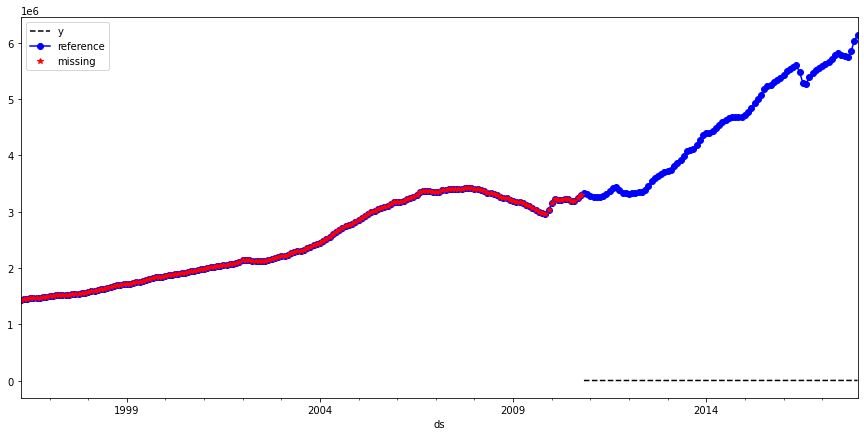

In [12]:
imputations = pd.DataFrame(test_ts[['Date', 'Zri_MultiFamilyResidenceRental', 'ZHVI_SingleFamilyResidence']])
imputations.rename(columns={'Zri_MultiFamilyResidenceRental':'y',
                            'ZHVI_SingleFamilyResidence':'reference',
                            'Date': 'ds'}, inplace=True)

imputations = imputations.assign(ds=imputations.ds.apply(lambda _ : datetime.strptime(_, "%Y-%m-%d")))
imputations.set_index('ds', inplace=True)

imputations = imputations.assign(missing=np.nan)
imputations.missing[imputations.y.isna()] = imputations.reference
print(imputations.info())

imputations.plot(style=['k--', 'bo-', 'r*'], figsize=(15, 7));

In [13]:
# Mean & Median
imputations = imputations.assign(FillMean=imputations.y.fillna(imputations.y.mean()))
imputations = imputations.assign(FillMed=imputations.y.fillna(imputations.y.median()))

# Rolling Mean & Median
imputations = imputations.assign(RollingMean=imputations.y.fillna(imputations.y.rolling(12, min_periods=1).mean()))
imputations = imputations.assign(RollingMed=imputations.y.fillna(imputations.y.rolling(12, min_periods=1).median()))

# Interpolation 
imputations = imputations.assign(InterpolLin=imputations.y.interpolate(method='linear', limit_direction='both'))
imputations = imputations.assign(InterpolTime=imputations.y.interpolate(method='time', limit_direction='both'))
imputations = imputations.assign(InterpolCubSpl=imputations.y.interpolate(method='spline', order=3, limit_direction='both'))

#### FIndings
- The imputation techniques are miserable as shown by R2 scores that make no sense
- Notably from the line graphs shown, the classic naive imputation technique of FillMean and / FillMed or Interpolate Time are the best for use at this time (**as a placeholder**) until another imputation technique is explored at a later time

In [14]:
impute_results = []

for method in list(imputations)[3:]:
    try:
        result = r2_score(imputations.reference, imputations[method])
        impute_results.append((method, result))
    except:
        pass
    
impute_results = pd.DataFrame(impute_results, columns=['Method', 'R2_score'])
impute_results

,Method,R2_score
0,FillMean,-6.467863
1,FillMed,-6.468427
2,InterpolLin,-6.468935
3,InterpolTime,-6.468935
4,InterpolCubSpl,-8.496712


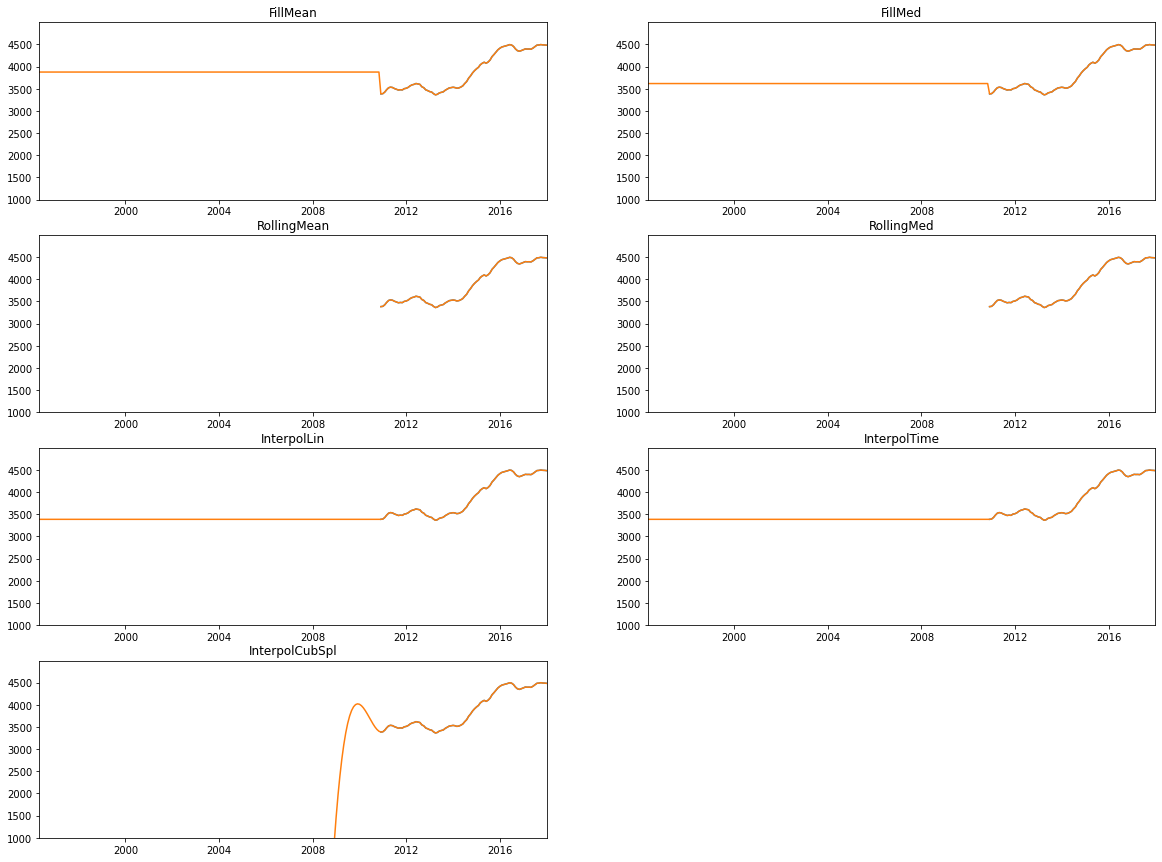

In [15]:
fig = plt.figure(1, figsize=(20, 15))
for i, method in enumerate(list(imputations)[3:]):
    fig.add_subplot(4, 2, i+1) 
    plt.plot(imputations[['y', method]])
    plt.ylim(1000, imputations.y.max() + 500)
    plt.xlim(imputations.index.min(), imputations.index.max())
    plt.title(method)

#### For all ZipCodes, fill the missing values by using `pandas.Series.interpolate()` specifying Time

In [24]:
interpol = ca_zips.copy()

interpol = interpol[['ds', 'ZipCode', 'ZHVI_SingleFamilyResidence', 'Zri_MultiFamilyResidenceRental']]
interpol.columns

Index(['ds', 'ZipCode', 'ZHVI_SingleFamilyResidence',
       'Zri_MultiFamilyResidenceRental'],
      dtype='object')

In [25]:
interpol.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 332663 entries, 0 to 332662
Data columns (total 4 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   ds                              332663 non-null  datetime64[ns]
 1   ZipCode                         332663 non-null  object        
 2   ZHVI_SingleFamilyResidence      299567 non-null  float64       
 3   Zri_MultiFamilyResidenceRental  84858 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 12.7+ MB


In [17]:
interpol['ds'] = interpol.Date.apply(lambda _ : datetime.strptime(_, "%Y-%m-%d"))
interpol.drop('Date', axis=1, inplace=True)
interpol.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 332663 entries, 0 to 332662
Data columns (total 4 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   ZipCode                         332663 non-null  object        
 1   ZHVI_SingleFamilyResidence      299567 non-null  float64       
 2   Zri_MultiFamilyResidenceRental  84858 non-null   float64       
 3   ds                              332663 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 12.7+ MB


In [18]:
interpol_time = interpol.copy()
interpol_time.set_index('ds', inplace=True)

interpol_time = interpol_time.assign(ZHVI_ITime=interpol_time.ZHVI_SingleFamilyResidence.interpolate(method='time', limit_direction='both'))
interpol_time = interpol_time.assign(ZRI_ITime=interpol_time.Zri_MultiFamilyResidenceRental.interpolate(method='time', limit_direction='both'))

interpol_time.drop(['ZHVI_SingleFamilyResidence', 'Zri_MultiFamilyResidenceRental'], axis=1, inplace=True)
interpol_time.rename(columns={'ZHVI_ITime':'ZHVI_SingleFamilyResidence',
                              'ZRI_ITime': 'Zri_MultiFamilyResidenceRental'}, inplace=True) 

display(interpol_time.head(3))
display(interpol_time.shape)
display(interpol_time.info())

,ZipCode,ZHVI_SingleFamilyResidence,Zri_MultiFamilyResidenceRental
ds,,,
1996-04-30,90001,114100.0,1552.0
1996-04-30,90002,105700.0,1552.0
1996-04-30,90003,103800.0,1552.0


(332663, 3)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 332663 entries, 1996-04-30 to 2017-12-31
Data columns (total 3 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ZipCode                         332663 non-null  object 
 1   ZHVI_SingleFamilyResidence      332663 non-null  float64
 2   Zri_MultiFamilyResidenceRental  332663 non-null  float64
dtypes: float64(2), object(1)
memory usage: 10.2+ MB


None

In [19]:
interpol_time = interpol_time.reset_index()
interpol_time['ZipCode'] = interpol_time['ZipCode'].astype('int32')

interpol_time.info()
interpol_time.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332663 entries, 0 to 332662
Data columns (total 4 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   ds                              332663 non-null  datetime64[ns]
 1   ZipCode                         332663 non-null  int32         
 2   ZHVI_SingleFamilyResidence      332663 non-null  float64       
 3   Zri_MultiFamilyResidenceRental  332663 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int32(1)
memory usage: 8.9 MB


,ds,ZipCode,ZHVI_SingleFamilyResidence,Zri_MultiFamilyResidenceRental
0,1996-04-30,90001,114100.0,1552.0
1,1996-04-30,90002,105700.0,1552.0
2,1996-04-30,90003,103800.0,1552.0


#### For all ZipCodes, fill the missing values with 0

In [20]:
interpol_0 = interpol.fillna(0)
interpol_0.set_index('ds', inplace=True)

display(interpol_0.shape)
display(interpol_0.info())
display(interpol_0.head(3))

(332663, 3)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 332663 entries, 1996-04-30 to 2017-12-31
Data columns (total 3 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ZipCode                         332663 non-null  object 
 1   ZHVI_SingleFamilyResidence      332663 non-null  float64
 2   Zri_MultiFamilyResidenceRental  332663 non-null  float64
dtypes: float64(2), object(1)
memory usage: 10.2+ MB


None

,ZipCode,ZHVI_SingleFamilyResidence,Zri_MultiFamilyResidenceRental
ds,,,
1996-04-30,90001,114100.0,0.0
1996-04-30,90002,105700.0,0.0
1996-04-30,90003,103800.0,0.0


In [21]:
interpol_0.to_pickle('../data/processed/interpolated_fillna0_df.pickle')
interpol_time.to_pickle('../data/processed/interpolated_fillnaTime_df.pickle')